# VGG on CIFAR - solutions
In this lab we will train a VGG model on the CIFAR dataset

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

It is recommended to use the GPU for this exercise

In [2]:

use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

### Load the CIFAR dataset

In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform)

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



0it [00:00, ?it/s]

100%|█████████▉| 169713664/170498071 [00:19<00:00, 14405281.27it/s]

Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar
Files already downloaded and verified


### Define the VGG architecture

In [0]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 

        return x


In [0]:
# Build the network and move its parameters to either GPU or CPU
net = VGG_convnet().to(device)

In [0]:
criterion = nn.CrossEntropyLoss()

my_lr=0.25


### Train the model on the train set

In [0]:
start=time.time()

optimizer=torch.optim.SGD(net.parameters(), lr=my_lr)

for epoch in range(1,30):

  for i, (x_batch, y_batch) in enumerate(trainloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used
    
    optimizer.zero_grad()  # Set all currenly stored gradients to zero 

    y_pred = net(x_batch)

    loss = criterion(y_pred, y_batch)

    loss.backward()

    optimizer.step()

    # Compute relevant metrics
    
    y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

    correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

    elapsed = time.time() - start  # Keep track of how much time has elapsed

    # Show progress every 20 batches 
    if not i % 20:
      print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')




### Evaluate the model on the test set

In [0]:
correct_total = 0

for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

  y_pred = net(x_batch)
  y_pred_max = torch.argmax(y_pred, dim=1)

  correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Accuracy on the test set: 0.792


### Define a function to show an input image

In [0]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

inverse_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
                                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])

# Function to show an image tensor
def show(X):
    X = invTrans(X)

    plt.imshow(np.transpose(X.numpy(), (1, 2, 0)))
    plt.show()

### Show the model's prediction for a random sample from the test set

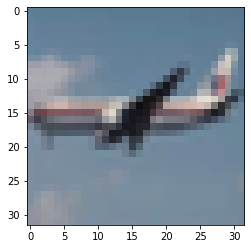

Confidence scores:
plane: 1.0
car: 2.1552328689846496e-22
bird: 5.393927492158834e-12
cat: 2.1109357005986464e-15
deer: 7.042923504625484e-21
dog: 1.3179952265231403e-22
frog: 1.1797641272214466e-21
horse: 8.030302506201037e-21
ship: 9.343617132439737e-19
truck: 2.1920653778728194e-21

Label with highest confidence score: plane

True label: plane


In [0]:
# choose a picture at random
im_minibatch, label_minibatch = iter(testloader).next()
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# diplay the picture
show(im)

# feed it to the net and display the confidence scores
prob = F.softmax(net.cpu()(im.unsqueeze(0)), dim=1)

print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(classes[i], p.item()) for i, p in enumerate(prob.squeeze())]))

print('\nLabel with highest confidence score: {}'.format(classes[torch.argmax(prob).item()]))
print('\nTrue label: {}'.format(classes[label]))